In [1]:
from tiffConverter import convert_to_numpy, convert_to_tiff
import tomopy

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def cropAndAlign(kevinProj, tomopyProj):
    #Crop to correct region like tomo projection
    w, h = tomopyProj.shape
    res = cv2.matchTemplate(kevinProj.astype(np.float32),tomopyProj.astype(np.float32),cv2.TM_CCOEFF_NORMED)
    loc = np.where( res == res.max())
    print(loc)
    pt = list(zip(*loc[::-1]))[0]
    print(pt)
    kevinProj = kevinProj[pt[1]:w + pt[1] , pt[0]: h+pt[0] ]

    return kevinProj, tomopyProj

def showHistogramComparison(kevinProj, tomopyProj_scaled):

    plotHeight = 8000
    plotwidth = 0.5

    # Define a common bin range and bin count
    common_range = (min(tomopyProj_scaled.min(), kevinProj.min()), max(tomopyProj_scaled.max(), kevinProj.max()))
    bin_count = 100
    
    # Compute histograms with the same bins
    hist1, bin_edges = np.histogram(tomopyProj_scaled, bins=bin_count, range=common_range)
    hist2, bin_edges = np.histogram(kevinProj, bins=bin_count, range=common_range)
    
    # Subtract the histograms
    hist_diff = hist2 - hist1

    # Plot the difference histogram
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    #Plotting
    fig1, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
    axs[0,0].imshow(tomopyProj_scaled)
    axs[0,0].set_title('Tomopy Projection')
    axs[1,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[1,0].set_title('Histogram of Tomopy Projection')
    # axs[1,0].set_ylim(0,plotHeight)
    axs[1,0].set_xlim(-plotwidth,plotwidth)
    
    axs[0,1].imshow(kevinProj)
    axs[0,1].set_title('Kevin Projection')
    axs[1,1].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    axs[1,1].set_title('Histogram of Kevin Projection')
    # axs[1,1].set_ylim(0,plotHeight)
    axs[1,1].set_xlim(-plotwidth,plotwidth)
    
    axs[2,0].hist(np.ndarray.flatten(tomopyProj_scaled), bins=bin_edges, alpha=0.5, color = 'blue')
    axs[2,0].hist(np.ndarray.flatten(kevinProj), bins=bin_edges, alpha=0.5, color = 'red')
    # axs[2,0].set_ylim(0,plotHeight)
    axs[2,0].set_xlim(-plotwidth,plotwidth)
    axs[2,0].set_title('Both histograms on top of eachother')
    
    
    # axs[2,1].plot(bin_centers, hist_diff, label='Difference (Hist1 - Hist2)', color='green', drawstyle='steps-mid')
    axs[2,1].bar(bin_centers, hist_diff, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='Difference (Hist1 - Hist2)', color='red')
    axs[2,1].legend()
    axs[2,1].set_title('Difference of Histograms (Hist1 - Hist2)')
    # axs[2,1].set_ylim(-plotHeight//2,plotHeight//2)
    axs[2,1].set_xlim(-plotwidth,plotwidth)
    
    plt.show()

In [3]:
#Import data
recon_location = "reconstructions/foamRecon_NotNormalized_baseCase_20241008-220859_SIRT_CUDA.tif"
tomo, tomo_scale_info = convert_to_numpy(recon_location)

float32


In [4]:
# plt.imshow(tomo[tomo.shape[0]//2], cmap='binary')
# plt.colorbar()
# plt.show()

## Scale tomography reconstruction

float32


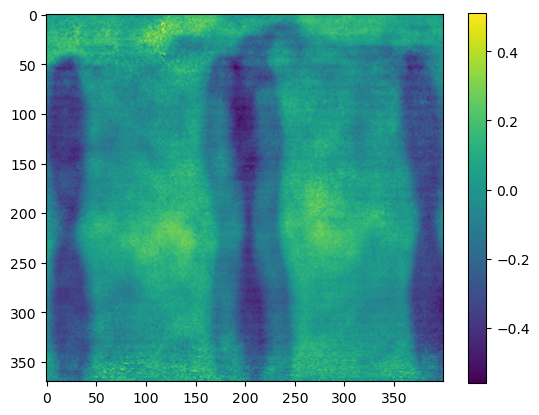

In [5]:
#Read in Kevin projection for reference
aligned_proj_location = "alignedProjections/aligned_baseCase_Filter_XCtip_20241004-100555.tif"

kevinProjections, kevin_proj_scale_info = convert_to_numpy(aligned_proj_location)
kevinProjOriginal = kevinProjections[0] #Every 72 projections
# plt.imshow(kevinProjOriginal[170:-2,210:-290])
plt.imshow(kevinProjOriginal[210:-70,250:-250])
plt.colorbar()
plt.show()

### Calculate scale information

(400, 464)


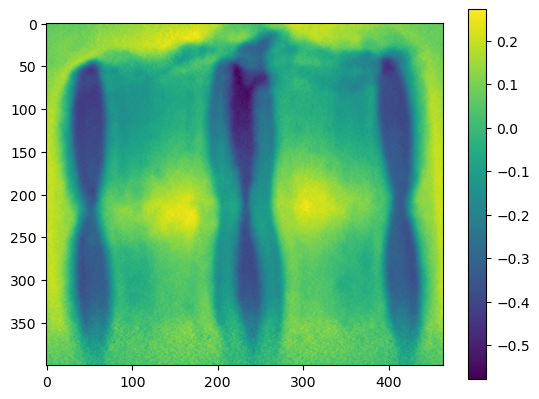

In [6]:
ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjOriginal = tomopy.project(tomo, ang) ## uncomment to first figure out the values for kevinProj_p5 and p95
tomopyProjOriginal = tomopyProjOriginal[0, 60:-40,300:-300]
print(np.shape(tomopyProjOriginal))
plt.imshow(tomopyProjOriginal)
plt.colorbar()
plt.show()

(array([210]), array([221]))
(221, 210)
0.8769497080755517
0.00859498498668314


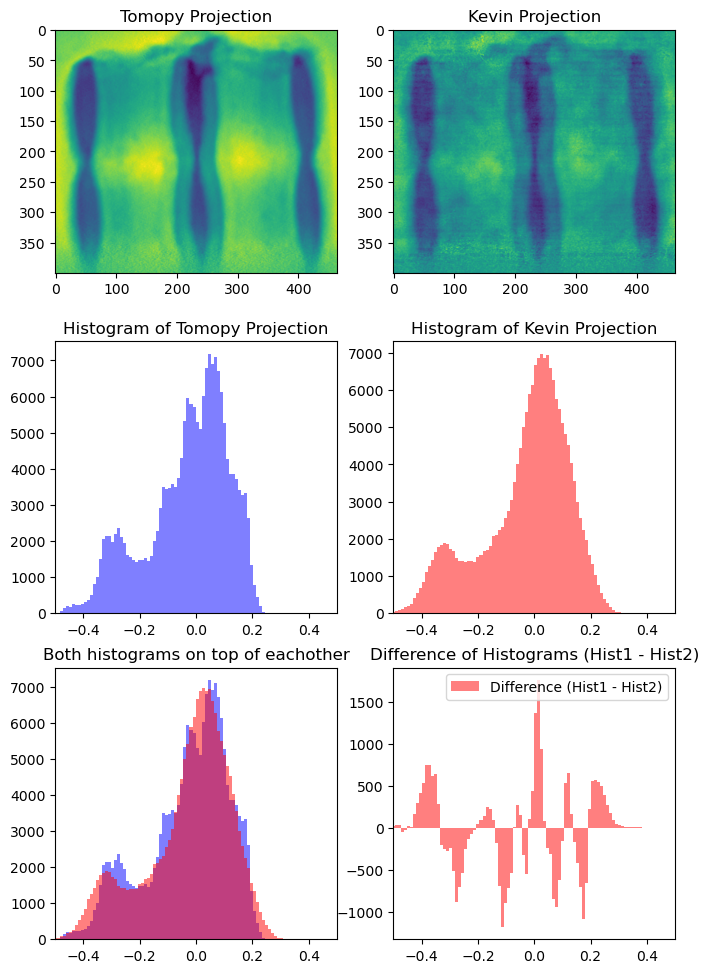

In [7]:
kevinProj, tomopyProj = cropAndAlign(kevinProjOriginal, tomopyProjOriginal)

# # Scale tomopyProj to match kevinProj using Least Squares Fit
flattened_array = tomopyProj.flatten()
flattened_column = flattened_array.reshape(-1,1)

A = np.hstack((np.ones((flattened_array.shape[0],1)), flattened_column))
B = kevinProj.flatten().reshape(-1,1)
X = np.linalg.lstsq(A,B, rcond=None)

shift = X[0][0][0]
scale = X[0][1][0]

print(scale)
print(shift)

tomopyProjNew = tomopyProj * scale + shift

# # Calculate the 1st and 99th percentiles of tomopyProj_cropped and kevinProj
# tomopyProj_cropped_p1, tomopyProj_cropped_p99 = np.percentile(tomopyProj, [1, 99])
# kevinProj_p1, kevinProj_p99 = np.percentile(kevinProj, [1, 99])
# print("kevinProj_p1: ", kevinProj_p1)
# print("kevinProj_p99: ", kevinProj_p99)
# # Normalize tomopyProj_cropped to [0, 1] based on its 5th and 95th percentiles
# tomopyProj = (tomopyProj - tomopyProj_cropped_p1) / (tomopyProj_cropped_p99 - tomopyProj_cropped_p1)
# # Scale to [kevinProj_p1, kevinProj_p99]
# tomopyProj = tomopyProj * (kevinProj_p99 - kevinProj_p1) + kevinProj_p1

showHistogramComparison(kevinProj, tomopyProjNew)
# showHistogramComparison(kevinProj, tomopyProj)

### Correct full Tomo

0.8769497080755517
0.00859498498668314


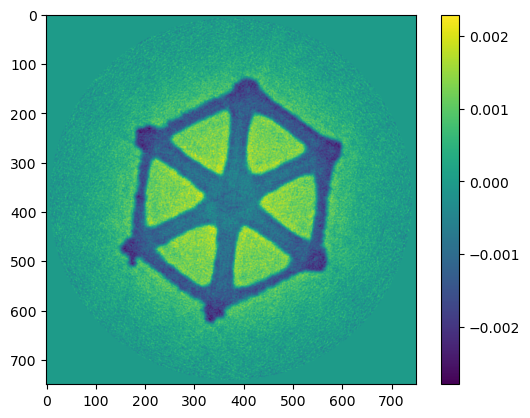

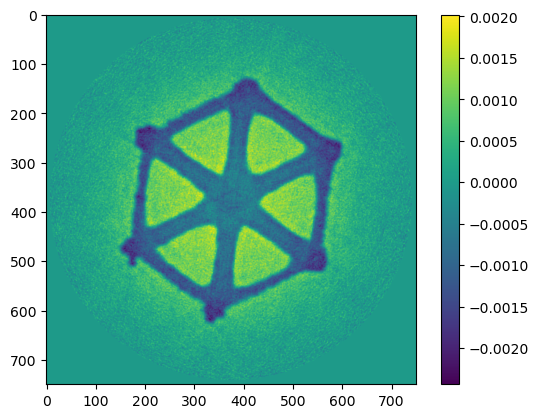

In [8]:
#Scale all parts of the reconstruction other than the part that is already listed as 0
tomo_nonzero_indices = tomo != 0
tomo_scaled = (tomo * scale + shift/750) * tomo_nonzero_indices #shift/750 so that overall shift in a projection through volume adds up to the needed shift
print(scale)
print(shift)
plt.imshow(tomo[280])
plt.colorbar()
plt.show()
plt.imshow(tomo_scaled[280])
plt.colorbar()
plt.show()
ang = tomopy.angles(5, 0, 360) #First angle should theoretically be the same no matter how many angles I project through
tomopyProjOriginal_scaled = tomopy.project(tomo_scaled, ang)[0, 60:-40,300:-300]

(array([210]), array([221]))
(221, 210)


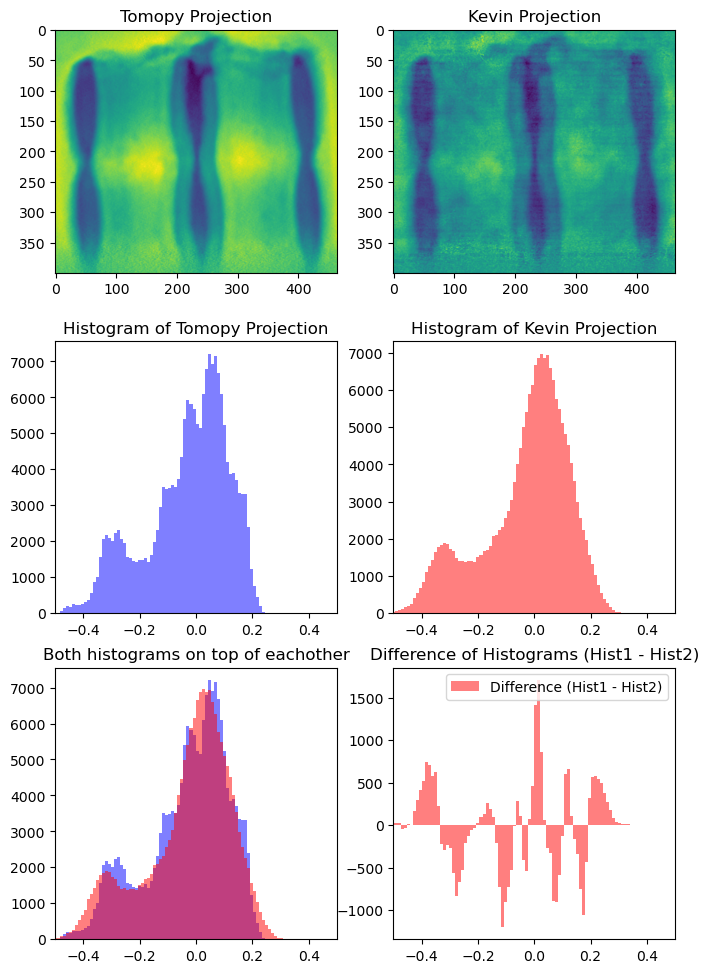

In [9]:
# kevinProj, tomopyProj = cropAndAlign(kevinProjOriginal, tomopyProj)
# showHistogramComparison(kevinProj, tomopyProj)

kevinProj, tomopyProj = cropAndAlign(kevinProjOriginal, tomopyProjOriginal_scaled)
showHistogramComparison(kevinProj, tomopyProj)

### Subtract Background
So that all air voxels are the same pixel value

In [10]:
tomo = tomo_scaled

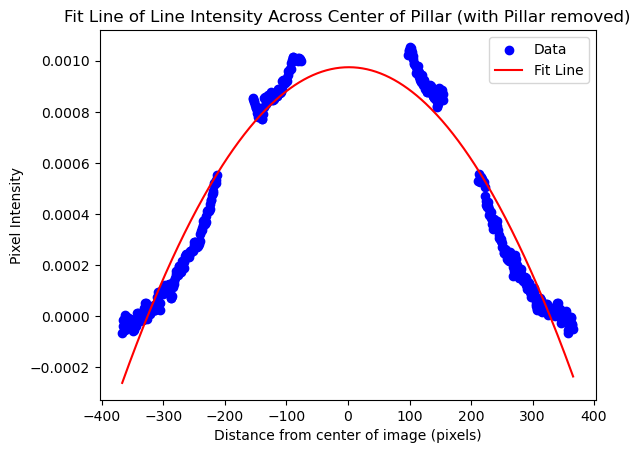

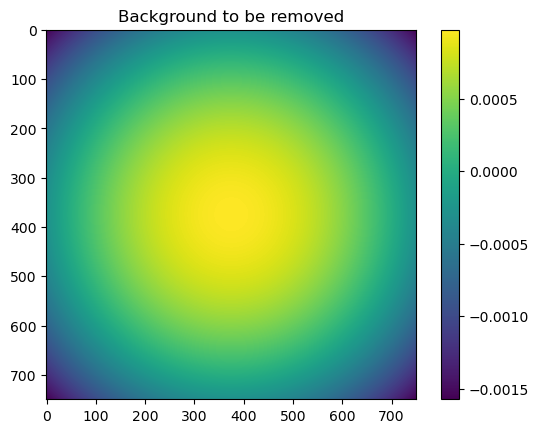

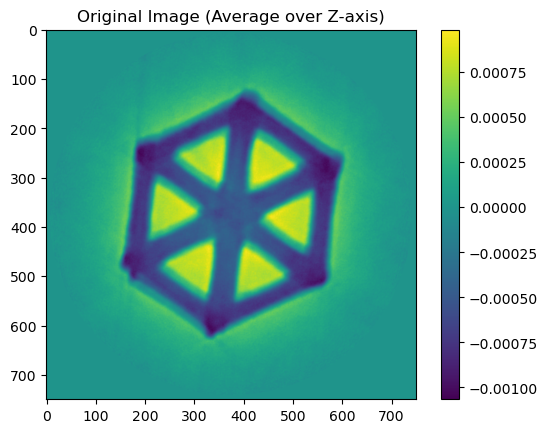

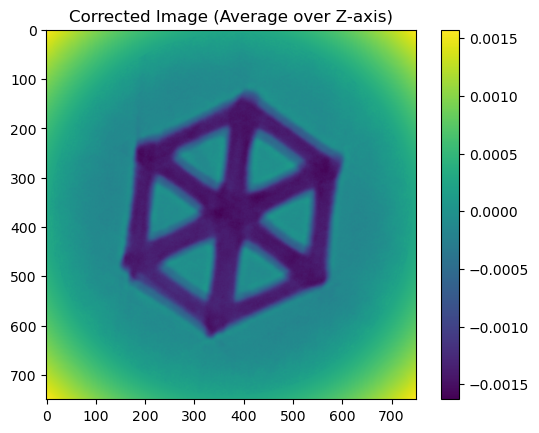

In [11]:
import csv
from scipy.optimize import curve_fit


#Create average over z-axis to calculate background from
image = np.mean(tomo[:, :, :], axis=0).astype(float)  # Averaging along the depth
x_c, y_c = image.shape[1] // 2, image.shape[0] // 2

# Path to your CSV file - Key points in the average pixel values through z-axis (looking down on pillar) to fit a curve to in order to subtract the background
file_path = "PlotValues.csv"

# Initialize empty lists for x and y
column1 = []
column2 = []

# Open and read the CSV file
with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the first line of the file
    
    # Iterate through the rows and extract the first two columns
    for row in reader:
        column1.append(float(row[0]))  # Convert to float or leave as string if preferred
        column2.append(float(row[1]))
        
column1 = [element * (750/17.47)-x_c for element in column1] #adjust scale to match distance-from-center rather than microns-from-edge

# # Fit the data with a tighter fit
# def model(r, a, b, c, d, e):  # Example: quadratic model
#     return a * r**4 + b * r**3 + c * r**2 + d * r + e

# Fit the data
def model(r, a, b, c):  # Example: quadratic model
    return a * r**2 + b * r + c


params, _ = curve_fit(model, column1, column2)

# Generate the fit line
fit_x = np.linspace(min(column1), max(column1), 500)  # Smooth range for plotting
fit_y = model(fit_x, *params)

# Plot the data and fit line
plt.scatter(column1, column2, label="Data", color="blue")  # Original data points
plt.plot(fit_x, fit_y, label="Fit Line", color="red")  # Fit line
plt.xlabel("Distance from center of image (pixels)")
plt.ylabel("Pixel Intensity")
plt.legend()
plt.title("Fit Line of Line Intensity Across Center of Pillar (with Pillar removed)")
plt.show()


# Create the 2D background model
y, x = np.indices(image.shape)
r_2d = np.sqrt((x - x_c)**2 + (y - y_c)**2)
radial_model = model(r_2d, *params)

#Display Results
plt.imshow(radial_model)
plt.title("Background to be removed")
plt.colorbar()
plt.show()

plt.imshow(image)
plt.title("Original Image (Average over Z-axis)")
plt.colorbar()
plt.show()

plt.imshow(image-radial_model)
plt.title("Corrected Image (Average over Z-axis)")
plt.colorbar()
plt.show()


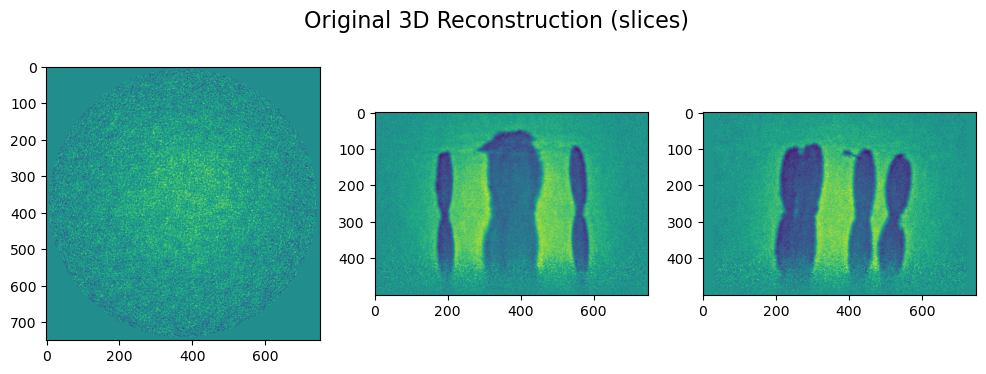

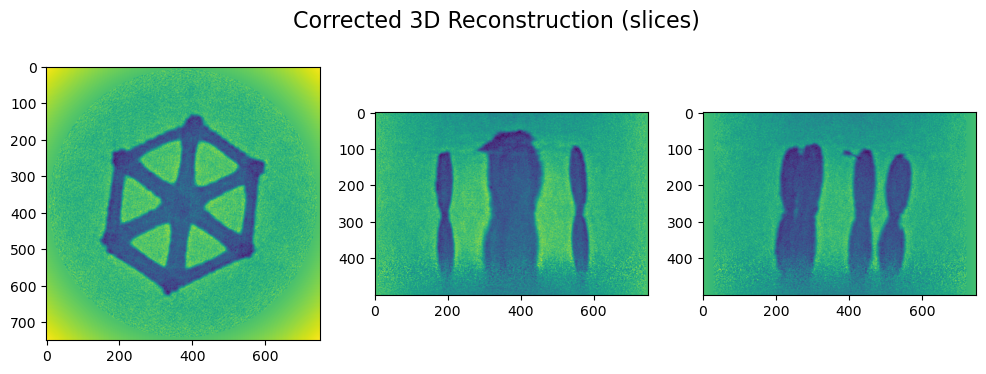

In [12]:
#Correct overall tomo
tomo_og =tomo
tomo_new = tomo-radial_model

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
fig1.suptitle("Original 3D Reconstruction (slices)", fontsize=16)
im0 = axs[0].imshow(tomo_og[5,:,:])
# plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(tomo_og[:,tomo_og.shape[1]//2,:])
# plt.colorbar(im0, ax=axs[1])
im2 = axs[2].imshow(tomo_og[:,:,tomo_og.shape[2]//3])
# plt.colorbar(im0, ax=axs[2])
plt.show()

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))
fig1.suptitle("Corrected 3D Reconstruction (slices)", fontsize=16)
im0 = axs[0].imshow(tomo_new[tomo_new.shape[0]//2,:,:])
# plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(tomo_new[:,tomo_new.shape[1]//2,:])
# plt.colorbar(im0, ax=axs[1])
im2 = axs[2].imshow(tomo_new[:,:,tomo_new.shape[2]//3])
# plt.colorbar(im0, ax=axs[2])
plt.show()

In [13]:
tomo = tomo_new

### Crop Region

500 750 750
(330, 510, 510)


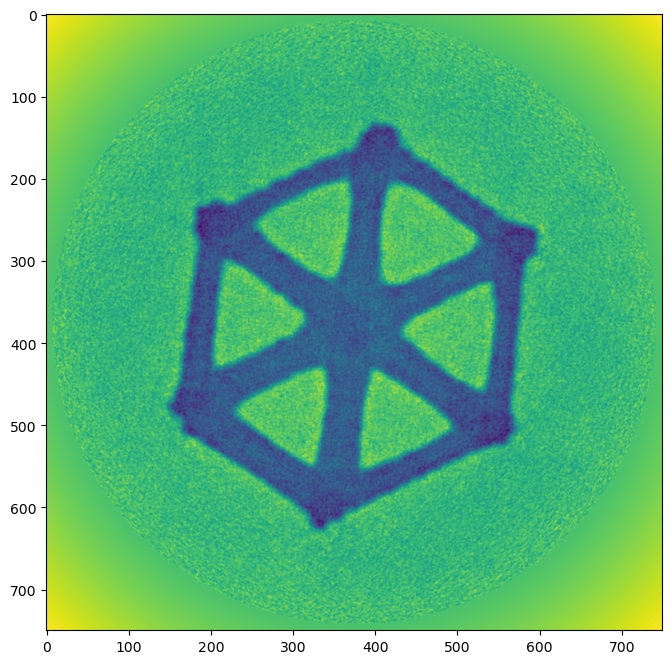

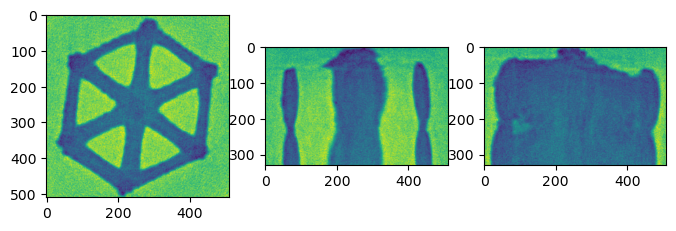

In [14]:

fig1, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
axs.imshow(tomo[tomo.shape[0]//2,:,:])
# axs.imshow(tomo[43,:,:])
# axs[1].imshow(tomo[:,tomo.shape[1]//2,:])
# axs[2].imshow(tomo[:,:,tomo.shape[2]//2])

#Volume dimensions
w,h,d = np.shape(tomo)
print(w,h,d)

fig1, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8,8))

#Dimensions for cropped image (used later for electron density)
a, b = 50, 380
c, d = 120, -120
e, f = 120, -120
axs[0].imshow(tomo[tomo.shape[0]//2,c:d,e:f])
axs[1].imshow(tomo[a:b,tomo.shape[1]//2,e:f])
axs[2].imshow(tomo[a:b,c:d,tomo.shape[2]//2])

tomo = tomo[a:b, c:d, e:f]
print(np.shape(tomo))

# # tomo = -tomo
# axs[0].imshow(tomo[tomo.shape[0]//2,:,:])
# axs[1].imshow(tomo[:,tomo.shape[1]//2,:])
# axs[2].imshow(tomo[:,:,tomo.shape[2]//3])

## Electron and Mass density calculations

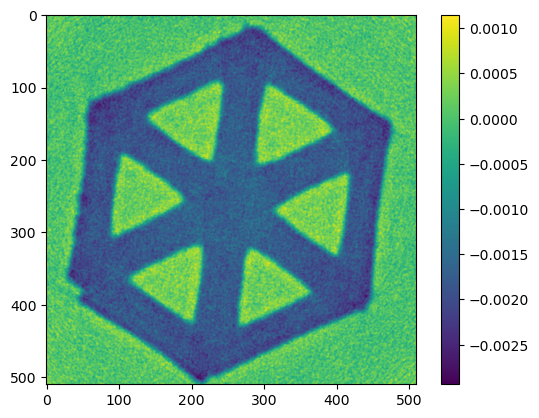

(330, 510, 510)


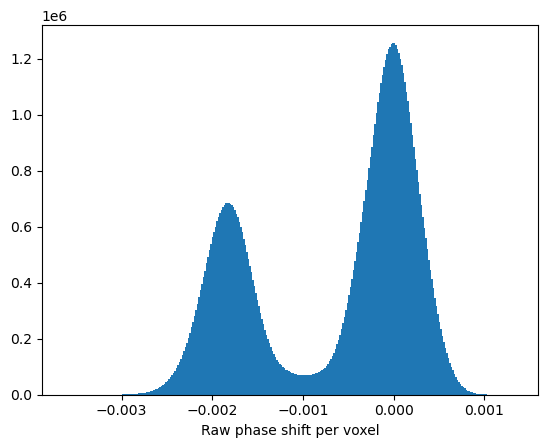

In [15]:
##Plot histogram of pixel volumes throughout whole cropped volume
rough_volume = tomo.copy()
plt.imshow(rough_volume[150])
plt.colorbar()
plt.show()

print(np.shape(rough_volume))
plt.hist(np.ndarray.flatten(rough_volume), 300, log=False)
plt.xlabel('Raw phase shift per voxel')
plt.show()

72
-5.118734893249993e-05


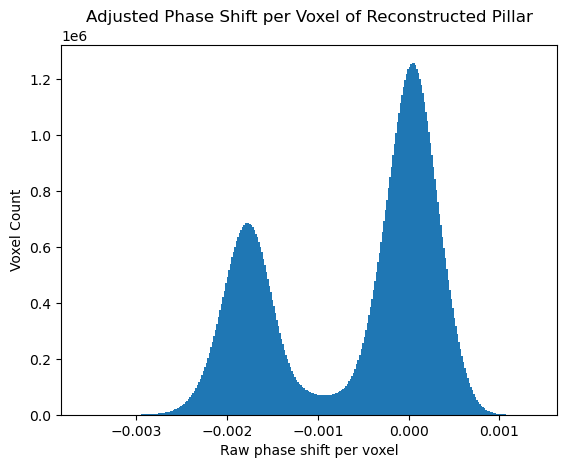

In [16]:
#Shift so phase difference of peak is 0
from scipy.signal import find_peaks
count, division = np.histogram(np.ndarray.flatten(rough_volume), 100)

print(np.argmax(count, axis = None))
ind = np.argmax(count, axis = None)

# #Set max phase shift to 0
# print(division[-1])
# rough_volume = rough_volume - division[-1]
# # rough_volume = rough_volume - np.percentile(division, 87)

##Set most common phase shift to 0
print(division[ind])
rough_volume = rough_volume - division[ind]

plt.hist(np.ndarray.flatten(rough_volume), 300, log=False)
plt.title("Adjusted Phase Shift per Voxel of Reconstructed Pillar")
plt.xlabel('Raw phase shift per voxel')
plt.ylabel('Voxel Count')
plt.show()

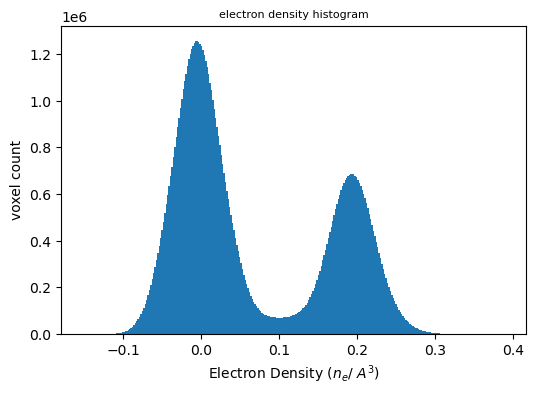

In [17]:
#Convert to electron density
import scipy.constants as constants
wavelength = 1239.8 / 8872 * 10**(-9)
lengthOfFullImageMicrons = 20.96*10**(-6) #In microns
lengthOfFullImagePixels = 900
voxel_depth = lengthOfFullImageMicrons/lengthOfFullImagePixels
r_0 = constants.physical_constants['classical electron radius'][0]

vol_proj_shift_edensity = - (rough_volume) / (wavelength * r_0) * (1/ voxel_depth) * (10**-10)**3

fig4, ax = plt.subplots(1, figsize=(6,4))
ax.hist(np.ndarray.flatten(vol_proj_shift_edensity), 300, log=False)
ax.set_title('electron density histogram', fontsize=8)
ax.set_xlabel('Electron Density ($n_e$/ $A^3$)')
ax.set_ylabel('voxel count')
plt.show()

Foams: A_bar =  1321.7496 , Z_bar =  699 , ratio =  1.8909150214592276
Foams with Salts: A_bar =  189.098 , Z_bar =  97 , ratio =  1.9494639175257733
Calculating for 0 percent Citrate
Adjusted ratio =  1.8909150214592276


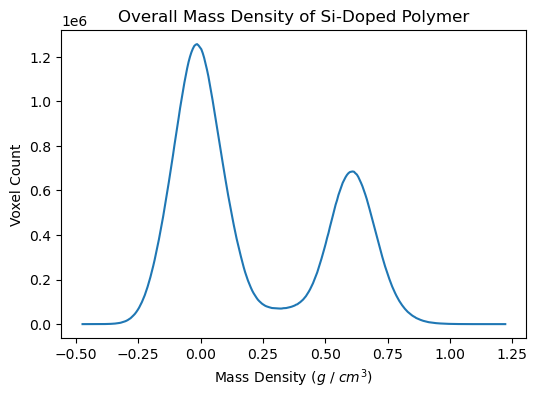

In [18]:
#View how mass density changes if chemical composition changes
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

# Foams (without salts) C48H72Si8O28
A_bar = 48 * 12.011 + 72 * 1.0078 + 8 * 28.086 + 28 * 15.999
Z_bar = 48 * 6 + 72 * 1 + 8 * 14 + 28 * 8 + 3
ratio = A_bar / Z_bar
print("Foams: A_bar = ", A_bar, ", Z_bar = ", Z_bar, ", ratio = ", ratio)

# # Bromide salt (assuming NaBr)
# A_bar_salt = 22.990 + 79.904
# Z_bar_salt = 11 + 35
# ratio_salt = A_bar_salt / Z_bar_salt
# print("Foams with Salts: A_bar = ", A_bar_salt, ", Z_bar = ", Z_bar_salt, ", ratio = ", ratio_salt)

# Citrate (C6H5O7-3)
A_bar_salt = 6 * 12.011 + 5 * 1.0078 + 7 * 15.999
Z_bar_salt = 6 * 6 + 5 * 1 + 7 * 8
ratio_salt = A_bar_salt / Z_bar_salt
print("Foams with Salts: A_bar = ", A_bar_salt, ", Z_bar = ", Z_bar_salt, ", ratio = ", ratio_salt)

# Initialize the plot
fig, ax = plt.subplots(1, figsize=(6, 4))

# Loop through different percentages of Citrate
percents = [0]
# percents = [0]
for percent in percents:
    print(f"Calculating for {percent * 100} percent Citrate")
    
    # Adjust the ratio for the given percent of bromide salts
    adjusted_ratio = ratio * (1 - percent) + (ratio_salt) * percent
    print("Adjusted ratio = ", adjusted_ratio)
    
    # Convert to mass density assuming composition (C48H72Si8O28)
    u = constants.physical_constants['atomic mass constant'][0]
    
    # Convert to mass density
    vol_proj_shift_mdensity = vol_proj_shift_edensity * u * adjusted_ratio
    
    # Convert kg/A^3 to g/cm^3
    vol_proj_shift_mdensity = vol_proj_shift_mdensity * 1000 * (10**8)**3
    
    # Calculate histogram data without plotting
    counts, bin_edges = np.histogram(np.ndarray.flatten(vol_proj_shift_mdensity), bins=300)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2  # Find bin centers
    
    # Plot line at tops of histogram bins
    ax.plot(bin_centers, counts, label=f'{percent * 100}% Citrate')

# Add title, labels, and legend
ax.set_title('Overall Mass Density of Si-Doped Polymer', fontsize=12)
ax.set_xlabel('Mass Density ($g$ / $cm^3$)')
ax.set_ylabel('Voxel Count')
# ax.set_xlim(0.24, 1)


# ax.legend(title='Percent Citrate')

# Show the plot
plt.show()


In [19]:
print(np.mean(vol_proj_shift_mdensity))

0.20592241528732239


## Calculating Average Density in Cylindrical Region

In [20]:
vol_proj_shift_mdensity = vol_proj_shift_mdensity.astype(np.float64)

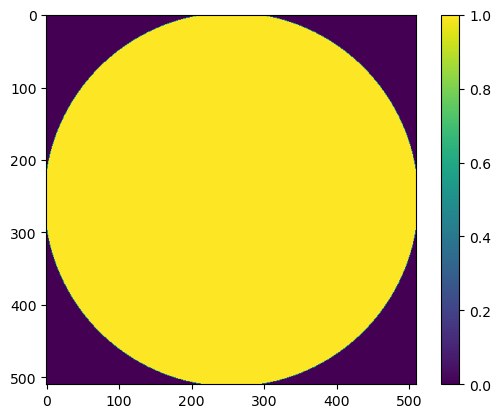

In [21]:
y, x = np.indices(vol_proj_shift_mdensity[50].shape)
y_c, x_c = vol_proj_shift_mdensity[50].shape
y_c = y_c//2
x_c = x_c//2

r_2d = np.sqrt((x - x_c)**2 + (y - y_c)**2)
pixelSize = 23.2910 #nanometers
baseRadius = 6000/pixelSize
mask = r_2d<baseRadius
plt.imshow(mask)
plt.colorbar()
plt.show()

In [22]:
experimentMask = vol_proj_shift_mdensity * (r_2d<baseRadius)

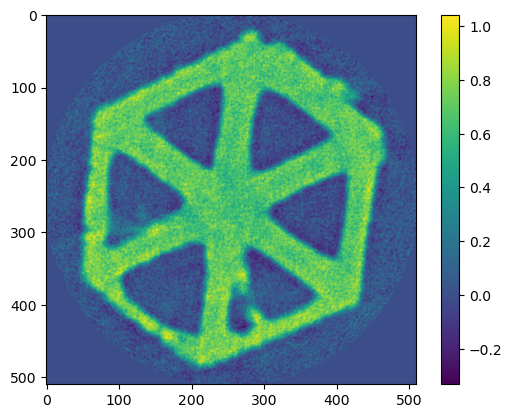

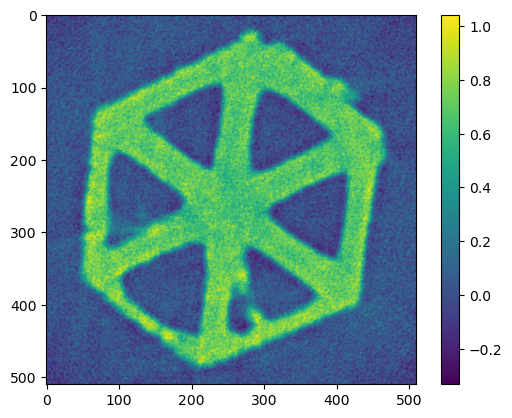

In [23]:
plt.imshow(experimentMask[70])
plt.colorbar()
plt.show()
plt.imshow(vol_proj_shift_mdensity[70])
plt.colorbar()
plt.show()

In [24]:
average = np.sum(experimentMask)/(np.sum(mask)*np.shape(experimentMask)[0])
print(average)

0.26008527738091897


## Other Calculations for Figures

In [24]:
#TODO: Width is mass density resolution
#Are widths the same
#Numerically deconvolve pillar peak with width of gaussian of air peak

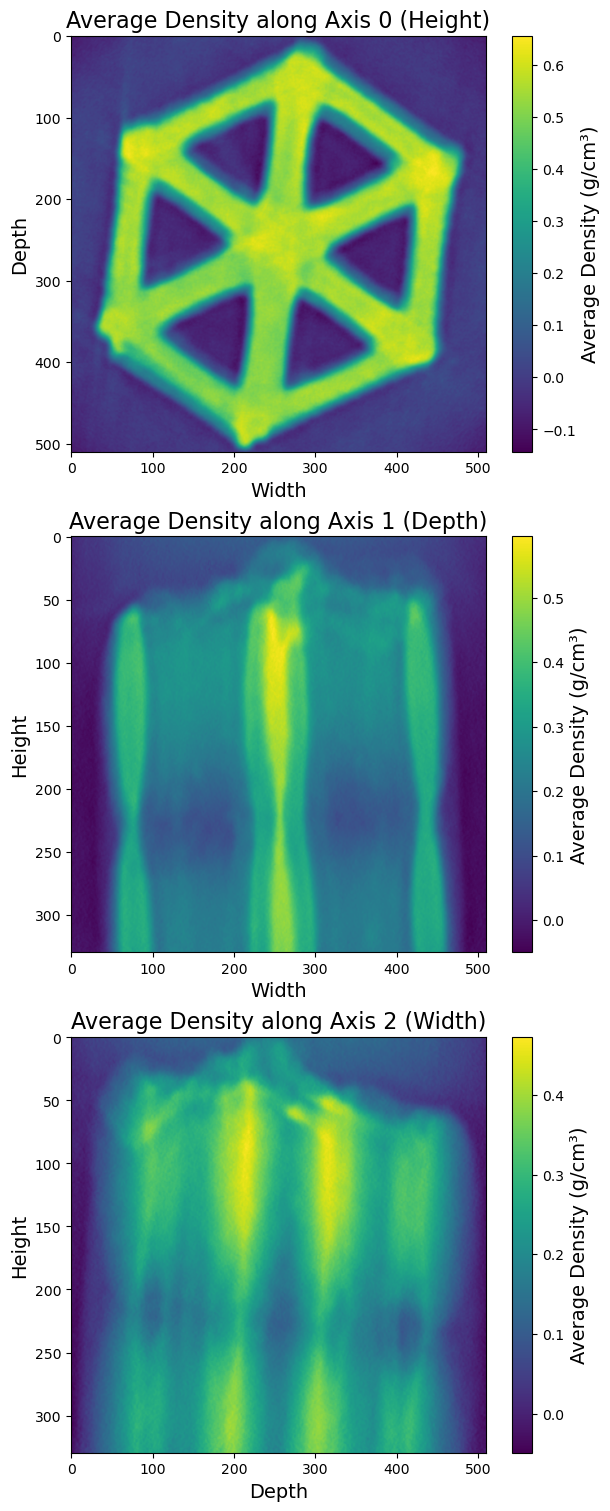

In [25]:
# Plot average density across different axes
import numpy as np
import matplotlib.pyplot as plt

def plot_averages_stacked(data_3d):
    """
    Averages a 3D array across all axes and plots the resulting 2D averages stacked vertically,
    with color bars on the right side of each plot.

    Parameters:
        data_3d (numpy.ndarray): Input 3D numpy array.
    """
    # Ensure the input is a 3D array
    if len(data_3d.shape) != 3:
        raise ValueError("Input array must be 3-dimensional.")

    # Compute average along each axis and cast to float
    avg_axis_0 = np.mean(data_3d, axis=0).astype(float)  # Averaging along the depth
    avg_axis_1 = np.mean(data_3d, axis=1).astype(float)  # Averaging along the height
    avg_axis_2 = np.mean(data_3d, axis=2).astype(float)  # Averaging along the width

    # Create a stacked vertical plot
    fig, axs = plt.subplots(3, 1, figsize=(6, 15), constrained_layout=True)

    smallFont = 14
    bigFont = 16
    # Plot for Axis 0
    im0 = axs[0].imshow(avg_axis_0, cmap='viridis', aspect='auto')
    axs[0].set_title("Average Density along Axis 0 (Height)", fontsize=bigFont)
    axs[0].set_xlabel("Width", fontsize=smallFont)
    axs[0].set_ylabel("Depth", fontsize=smallFont)
    cbar0 = fig.colorbar(im0, ax=axs[0], orientation='vertical')
    cbar0.set_label("Average Density (g/cm³)", fontsize=smallFont)

    # Plot for Axis 1
    im1 = axs[1].imshow(avg_axis_1, cmap='viridis', aspect='auto')
    axs[1].set_title("Average Density along Axis 1 (Depth)", fontsize=bigFont)
    axs[1].set_xlabel("Width", fontsize=smallFont)
    axs[1].set_ylabel("Height", fontsize=smallFont)
    cbar1 = fig.colorbar(im1, ax=axs[1], orientation='vertical')
    cbar1.set_label("Average Density (g/cm³)", fontsize=smallFont)

    # Plot for Axis 2
    im2 = axs[2].imshow(avg_axis_2, cmap='viridis', aspect='auto')
    axs[2].set_title("Average Density along Axis 2 (Width)", fontsize=bigFont)
    axs[2].set_xlabel("Depth", fontsize=smallFont)
    axs[2].set_ylabel("Height", fontsize=smallFont)
    cbar2 = fig.colorbar(im2, ax=axs[2], orientation='vertical')
    cbar2.set_label("Average Density (g/cm³)", fontsize=smallFont)

    plt.show()

# Plot the averages
plot_averages_stacked(vol_proj_shift_mdensity)
# plot_averages_stacked(experimentMask)

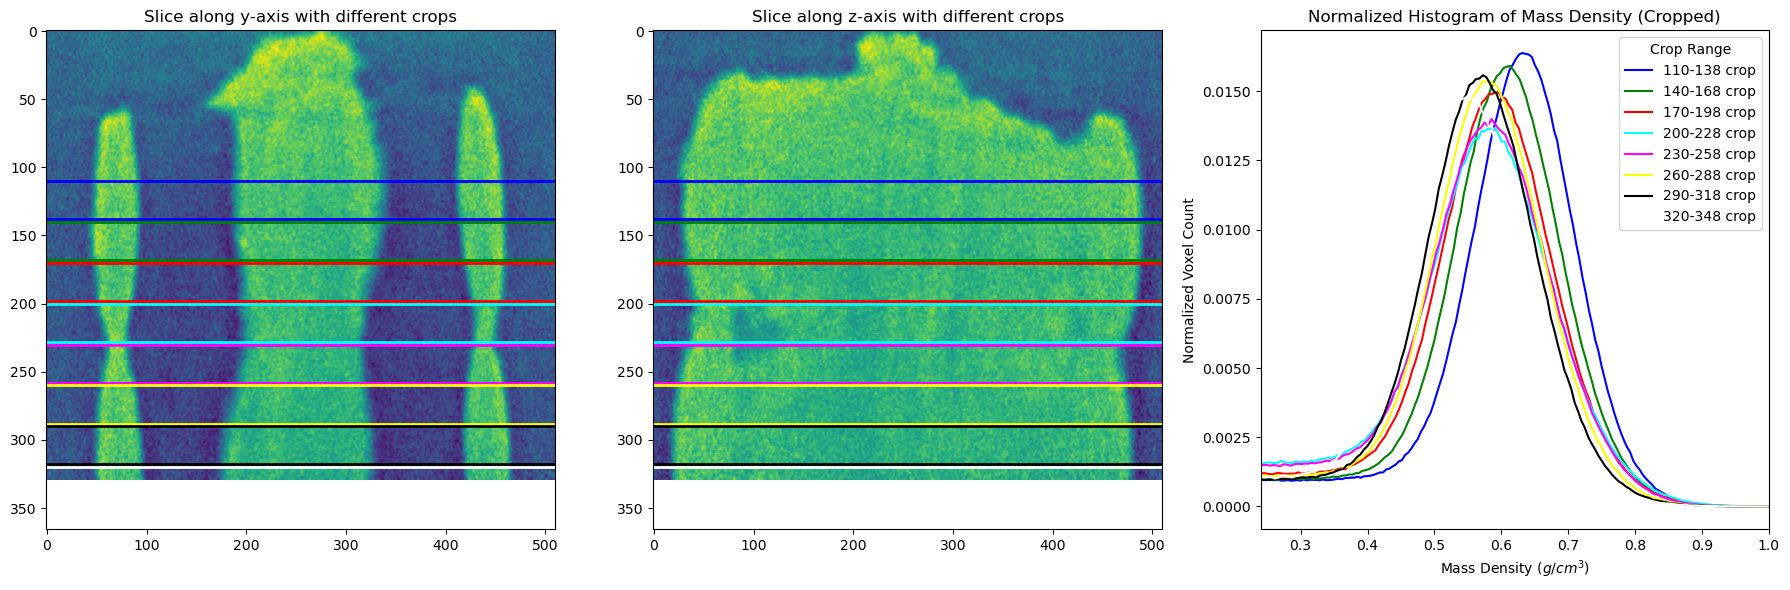

In [26]:
#View density distribution of different horizontal slice ranges of pillar reconstruction

import numpy as np
import matplotlib.pyplot as plt

# Define multiple crop ranges to loop over
crop_ranges = [(110,138),(140, 168),(170,198), (200,228), (230, 258), (260,288), (290, 318), (320,348)]
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white']

# Create the figure with subplots arranged in a 1x3 layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(vol_proj_shift_mdensity[:, 510 // 2, :], aspect='auto')
axs[1].imshow(vol_proj_shift_mdensity[:, :, 510 // 2], aspect='auto')

# Loop through each crop range and plot
for i, (cropTop, cropBottom) in enumerate(crop_ranges):
    # Plot the first slice with crop lines
    axs[0].axhline(y=cropTop, color=colors[i], linestyle='-', linewidth=2)
    axs[0].axhline(y=cropBottom, color=colors[i], linestyle='-', linewidth=2)
    axs[0].set_title("Slice along y-axis with different crops")

    # Plot the second slice with crop lines
    axs[1].axhline(y=cropTop, color=colors[i], linestyle='-', linewidth=2)
    axs[1].axhline(y=cropBottom, color=colors[i], linestyle='-', linewidth=2)
    axs[1].set_title("Slice along z-axis with different crops")

    # Calculate histogram for the cropped region
    counts, bin_edges = np.histogram(
        np.ndarray.flatten(vol_proj_shift_mdensity[cropTop:cropBottom]),
        bins=300
    )
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2  # Find bin centers
    
    # Mask out bins with values below 0.24
    mask = bin_centers >= 0.24
    bin_centers = bin_centers[mask]
    counts = counts[mask]
    
    # Normalize the histogram
    bin_widths = np.diff(bin_edges)[:-1]  # Get the width of each bin
    counts_normalized = counts / (counts.sum() * bin_widths.sum())  # Normalize to make the area under the curve = 1

    # Plot the normalized histogram for this crop range
    axs[2].plot(bin_centers, counts_normalized, label=f'{cropTop}-{cropBottom} crop', color=colors[i])
    axs[2].set_xlim(0.24, 1)
    axs[2].set_title("Normalized Histogram of Mass Density (Cropped)")
    axs[2].set_xlabel("Mass Density ($g/cm^3$)")
    axs[2].set_ylabel("Normalized Voxel Count")

# Add a legend to the histogram subplot
axs[2].legend(title="Crop Range")

# Adjust layout and show plot
plt.tight_layout()
plt.show()
